In [1]:
# File and Data Manipulation
import os                       # interacting with the operating system
import glob                     # retrieving files/pathnames matching a specified pattern
from collections import Counter # counting hashable objects
import shutil                   # high-level file operations
import pickle                   # serializing and de-serializing Python object structures

# File and Temporary Data Management
import tempfile  # for creating temporary files and directories

# Data Analysis
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis

# Geospatial Data Handling
import geopandas as gpd         # working with geospatial data

# Data Visualization
import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
import matplotlib.colors as mcolors   # colors for legend
import matplotlib.patches as mpatches # drawing patches (shapes) for legend
from matplotlib.ticker import MaxNLocator     # control the maximum number of ticks on plots
from matplotlib.ticker import MultipleLocator # control tick intervals on plots
import matplotlib.ticker as mticker           # advanced tick formatting and placement
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset for colorbar

# Raster Operations
import rasterio                       # core library
from rasterio.plot import show        # for displaying raster images

# Data Transformation and Resampling
from rasterio.enums import Resampling # different resampling algorithms
from rasterio.warp import calculate_default_transform # transformation calculation for reprojecting
from rasterio.warp import reproject   # for reprojecting raster data

# Geospatial Analysis and Masking
from rasterio.mask import mask              # masking raster data based on shapes
from rasterio.features import geometry_mask # creating masks from geometric shapes

# Advanced Raster Operations
from rasterio.merge import merge          # merging multiple raster datasets
from rasterio.plot import plotting_extent # plotting extent for matplotlib alignment
from rasterio.crs import CRS              # handling Coordinate Reference Systems

# Memory Handling and I/O Operations
from rasterio.io import MemoryFile        # in-memory raster data operations

# Suppress Warnings
import warnings                   # handling warnings
warnings.filterwarnings("ignore") # Suppress all warnings (use with caution!)

In [2]:
#Clip Raster to a Shapefile
def clip_raster_by_geometry(raster_path, geometry, output_path):
    """
    Clip a raster based on given geometry.

    Parameters:
    - raster_path (str): Path to the input raster file.
    - geometry (geopandas.GeoSeries or GeoDataFrame): The geometry to clip with.
    - output_path (str): Path to the output clipped raster file.
    """
    
    # Check if the output file already exists
    if os.path.exists(output_path):
        print(f"The file {output_path} already exists!")
        return
    
    with rasterio.open(raster_path) as src:
        clipped, transform = mask(src, geometry, crop=True)
        clipped_meta = src.meta.copy()  # Get metadata of the original raster
        clipped_meta.update({
            "driver": "GTiff", 
            "height": clipped.shape[1], 
            "width": clipped.shape[2], 
            "transform": transform
        })

        with rasterio.open(output_path, "w", **clipped_meta) as dest:
            dest.write(clipped)
            
# Reproject Data for Area Calculatons# Reproject Data for Area Calculatons
def reproject_raster(input_raster, output_raster, new_crs):
    """Reproject a raster to a new coordinate reference system."""

    # Check if the output file already exists
    if os.path.exists(output_raster):
        print(f"Output raster {output_raster} already exists!")
        return

    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, new_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': new_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=new_crs,
                    resampling=Resampling.bilinear
                )
    print(f"Raster reprojected to {new_crs} and saved as {output_raster}.")

In [3]:
# Define Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')

# Yenisey Watershed (Shapefile)
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Lakes (Shapefile)
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

# Open watershed boundary dictionary
with open('watersheds_gdfs.pkl', 'rb') as file:
    watersheds_gdfs = pickle.load(file)
print("Dictionary loaded successfully.")

Dictionary loaded successfully.


In [4]:
# Angara Confluence
angara = watersheds_gdfs['w_3227']
angara_confluence = watersheds_gdfs['w_3225']

(46.37338787934154, 71.62704695372541)

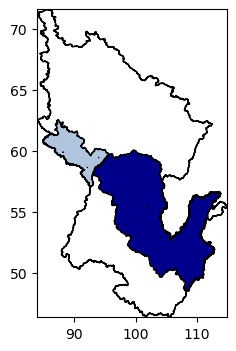

In [5]:
# Quick Plot
fig, ax = plt.subplots(figsize=(4, 4))
#ax.set_title('EcoRegions (Yenisey River Basin)', fontsize=12)
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=2)
angara.plot(ax=ax, color='darkblue', edgecolor='black', lw=1)
angara_confluence.plot(ax=ax, color='lightsteelblue', edgecolor='black', lw=1)
#gpd_lakes.plot(ax=ax, edgecolor='black', color='none', lw=0.5, zorder=6)
# Setting the plot limits to the extent of the eco data
xmin, ymin, xmax, ymax = AGRO_Watershed.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [6]:
# Calculate the total area in square kilometers
angara_confluence_3573 = angara_confluence.to_crs(3573)
angara_confluence_3573_area_km2 = angara_confluence_3573.geometry.area.sum() / 1e6
print(f"Total = {angara_confluence_3573_area_km2:.0f} km2")

Total = 125291 km2


### ESA Land Coverage

In [7]:
# Check CRS before running
input_file = 'ESA_Land_Cover_2020_mosaicked_downsampled_8.tif'
with rasterio.open(input_file) as src:
    meta = src.meta
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 42990,
 'height': 35140,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0007186522272956172, 0.0, 83.9872837235049,
        0.0, -0.0007186522272956172, 71.62705443417977)}

In [8]:
%%time
# Clip Raster to the Yenisey River Basin Watershed
input_file = 'ESA_Land_Cover_2020_mosaicked_downsampled_8.tif'
output_file = "ESA_angara_confluence.tif"
geometry = angara_confluence.geometry
clip_raster_by_geometry(input_file, geometry, output_file)

The file ESA_angara_confluence.tif already exists!
Wall time: 997 µs


In [9]:
# Use this for Area Calculations
input_file = 'ESA_Land_Cover_2020_mosaicked_downsampled_8_3573.tif'
ESA_angara_confluence_3573 = "ESA_angara_confluence_3573.tif"
angara_confluence_3573 = angara_confluence.to_crs(3573)
geometry = angara_confluence_3573.geometry
clip_raster_by_geometry(input_file, geometry, ESA_angara_confluence_3573)

The file ESA_angara_confluence_3573.tif already exists!


In [10]:
# Corrected land cover classification colormap
land_cover_dict = {
    10: ("#006400", 'Tree Cover'),
    20: ("#ffbb22", 'Shrub Land'),
    30: ("#ffff4c", 'Grass Land'),
    40: ("#f096ff", 'Crop Land'),
    50: ("#fa0000", 'Built-Up'),
    60: ("#b4b4b4", 'Bare Vegetation'),
    70: ("#f0f0f0", 'Snow and Ice'),
    80: ("#0064c8", 'Permanent Water'),
    90: ("#0096a0", 'Herbaceous Wetland'),
    95: ("#00cf75", 'Mangroves'),
    100: ("#fae6a0", 'Moss and Lichen')
}

# Open the reprojected raster
with rasterio.open(ESA_angara_confluence_3573) as src:
    data = src.read(1)
    transform = src.transform
    pixel_size_x, pixel_size_y = src.res

# Flatten the data array and remove nodata values
nodata = 0  # Assuming 0 is the nodata value
data_flat = data[data != nodata]

# Calculate unique classes and their counts
unique_classes, counts = np.unique(data_flat, return_counts=True)

# Filter only relevant classes and values
relevant_classes = [cls for cls in unique_classes if cls in land_cover_dict]
colors = [land_cover_dict[cls][0] for cls in relevant_classes]
labels = [land_cover_dict[cls][1] for cls in relevant_classes]
relevant_counts = [counts[np.where(unique_classes == cls)[0][0]] for cls in relevant_classes]

# Convert counts to km^2 using raster resolution (area of 1 pixel)
pixel_area_km2 = abs(transform[0] * transform[4]) / (10**6)  # Assuming that transform gives pixel size in meters
area_km2_values = [count * pixel_area_km2 for count in relevant_counts]

In [11]:
# Create a DataFrame
df_esa = pd.DataFrame({
    'Land_Cover_Class': [land_cover_dict[cls][1] for cls in relevant_classes],
    'Color': [land_cover_dict[cls][0] for cls in relevant_classes],
    'Area_km2': area_km2_values
})

# Fixinssss
df_esa['Land_Cover_Class'] = ['Tree\nCover', 
                              'Shrub\nLand',
                              'Grass\nLand', 
                              'Crop\nLand', 
                              'Built-Up', 
                              'Bare\nVegetation',
                              'Snow\nand Ice', 
                              'Permanent\nWater', 
                              'Herbaceous\nWetland',  
                              'Mangroves',
                              'Moss and\nLichen']

# Set the class codes (like 10, 20, 30, etc.) as the index
df_esa.index = relevant_classes

# Calculate the total area from shapefile
#angara_confluence_3573_total_area_shapefile_km2

# Calculate the percent area for each class and add it as a new column to the DataFrame
df_esa['Percent_Area'] = (df_esa['Area_km2'] / angara_confluence_3573_area_km2) * 100

df_esa = df_esa.sort_values(by='Percent_Area', ascending=False)

In [12]:
total_area_esa = df_esa['Area_km2'].sum()
xx = (total_area_esa/angara_confluence_3573_area_km2)*100
print('ESA Coverage versus total coverage')
print(xx)

ESA Coverage versus total coverage
91.06442645712288


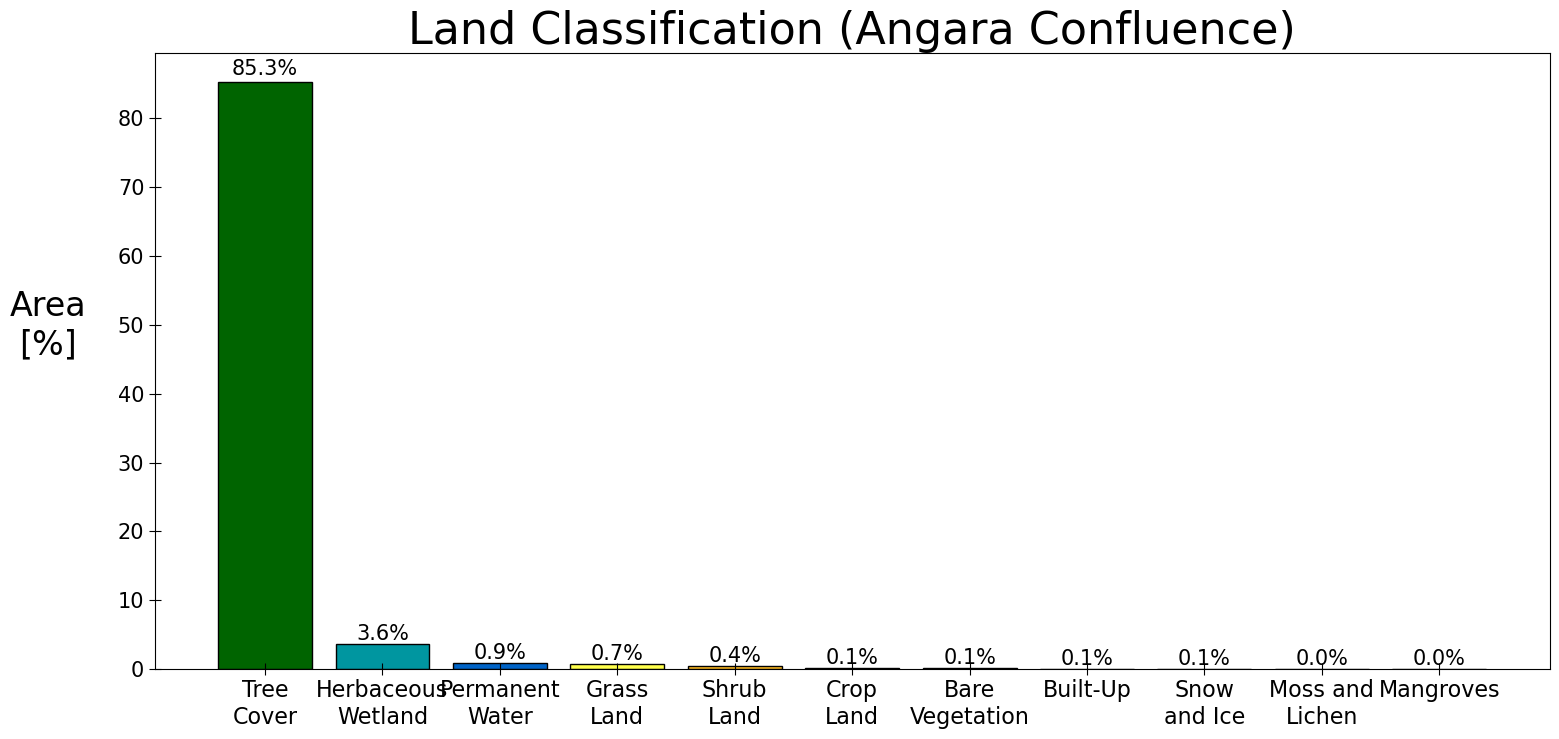

In [13]:
# Create the bar plot using the top 15 records
fig, ax = plt.subplots(figsize=(18, 8))
bars = ax.bar(df_esa['Land_Cover_Class'], df_esa['Percent_Area'], color=df_esa['Color'], edgecolor='black', align='center')

# Set title and labels
ax.set_title('Land Classification (Angara Confluence)', fontsize=32)
ax.set_ylabel('Area\n[%]', fontsize=24, labelpad=50, rotation=0)
#ax.set_xlabel('Watershed Code', labelpad=50, fontsize=24)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=18)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=18)

# Rotate x labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.yticks(fontsize=15)

# Add text above each bar
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    # Multiply by 100 to convert proportion to percentage
    percentage = df_esa['Percent_Area'].iloc[idx]
    # Format with one decimal place and add a percentage sign
    ax.text(bar.get_x() + bar.get_width()/2, 
            yval + 0.005*yval, 
            '{:.1f}%'.format(percentage), 
            ha='center', va='bottom', fontsize=15)


#fig.savefig("xxx.png", dpi=600, bbox_inches='tight')
fig.savefig("Chomiak_Yenisey_Final_Maps\Chomiak_Angara_Confluence_ESA_Barplot.png", dpi=600, bbox_inches='tight')

## Plot

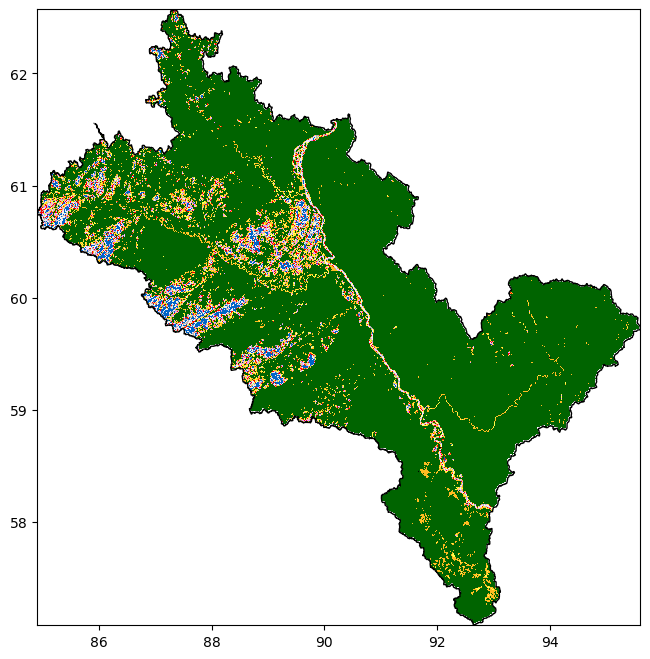

In [14]:
# Land cover classification colormap for plotting
class_dict = {
    0: (0, 0, 0, 0),  # Transparent color for no-data
    10: "#006400", # Tree Cover
    20: "#ffbb22", # Shrub Land
    30: "#ffff4c", # Grass Land
    40: "#f096ff", # Crop Land
    50: "#fa0000", # Built-Up
    60: "#b4b4b4", # Bare Vegetation
    70: "#f0f0f0", # Snow and Ice
    80: "#0064c8", # Permanent Water
    90: "#0096a0", # Herbaceous Wetland
    95: "#00cf75", # Mangroves
    100: "#fae6a0" # Moss and Lichen
}

# Convert the dictionary to a colormap
colors = [class_dict[key] for key in sorted(class_dict.keys())]
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(sorted(class_dict.keys()), cmap.N)

with rasterio.open(output_file) as src:
    data = src.read(1)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
# Plotting the GeoDataFrames as subplots
fig, ax = plt.subplots(figsize=(8, 8))

# Raster Data
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) 
# Vector Data
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1)

fig.savefig("Chomiak_Yenisey_Final_Maps\Chomiak_Angara_Confluence_ESA.png", dpi=600, bbox_inches='tight')

(59.0, 61.25)

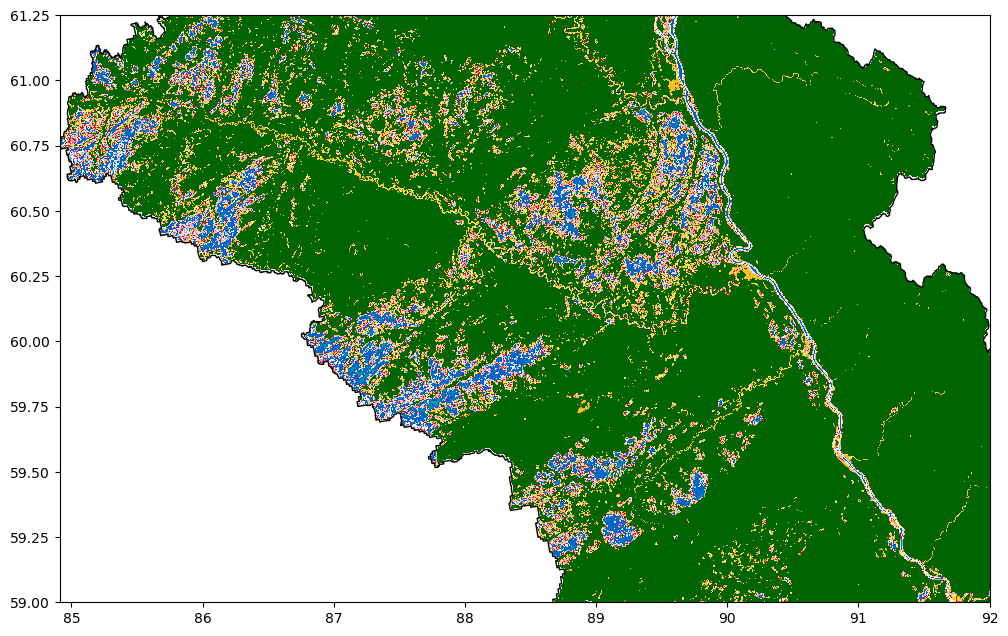

In [15]:
with rasterio.open(output_file) as src:
    data = src.read(1)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
# Plotting the GeoDataFrames as subplots
fig, ax = plt.subplots(figsize=(12, 12))

# Raster Data
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) 
# Vector Data
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1)

xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds
ax.set_xlim(xminac, 92)
ax.set_ylim(59, 61.25)

In [16]:
co2 = 'water_clean.csv'
df = pd.read_csv(co2)
df = df.drop(columns='date_time.1')
df.index = df['date_time']
df.index = pd.to_datetime(df.index)
df['year'] = pd.DatetimeIndex(df['date_time']).year
df['month'] = pd.DatetimeIndex(df['date_time']).month
df['day'] = pd.DatetimeIndex(df['date_time']).day
df['hour'] = pd.DatetimeIndex(df['date_time']).hour
df.index = pd.to_datetime(df.index)
df = df.drop(columns='date_time')
df.head(1)

,ch4_w,ich4_w,co2_w,ico2_w,lat_w,lon_w,sog_w,cog_w,t_air_w,rh_w,...,swr_w,lwr_w,t_rad_w,u_w,u_dir_w,t_adcp_w,year,month,day,hour
date_time,,,,,,,,,,,,,,,,,,,,,
2016-07-23 13:08:00,24.481255,-53.68805,731.541816,-17.727553,56.239426,93.417639,10.683333,339.84,24.7,41.638462,...,33.688939,379.440578,26.183489,2.968831,227.084756,8.231429,2016,7,23,13


In [17]:
def aggregate_stats(df, freq):
    """
    Aggregates statistics (mean, standard deviation, maximum, minimum) 
    for all numeric columns in a DataFrame, grouping the data by a specified frequency.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    freq (str): The frequency string to group the data.

    Returns:
    pd.DataFrame: A DataFrame containing the aggregated statistics for each numeric column.
    """
    # Filter out non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Group by and calculate statistics
    df_mean = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).mean()
    df_std = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).std().add_suffix('_std')
    df_max = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).max().add_suffix('_max')
    df_min = numeric_df.groupby(pd.Grouper(freq=freq, sort=True)).min().add_suffix('_min')
    
    # Concatenate results along the columns axis
    result = pd.concat([df_mean, df_std, df_max, df_min], axis=1)
    
    return result

In [18]:
# Resample to Hourly
df_30T = aggregate_stats(df, freq='30T')

In [19]:
# Extract the date component from the index (which is 'date_time')
df_30T['date'] = df_30T.index.date

# Group the data by each day
group_1 = df_30T.groupby('date')

# Create a dictionary with each day as a key and the corresponding DataFrame as the value
daily_data_dict_1 = {str(day): group for day, group in group_1}

In [20]:
angara_1a = daily_data_dict_1['2016-07-25']
angara_1b = daily_data_dict_1['2016-07-26']
angara_1c = daily_data_dict_1['2016-07-27']
angara_1d = daily_data_dict_1['2016-07-28']
combined_angara = pd.concat([angara_1a, angara_1b, angara_1c, angara_1d])

combined_angara = combined_angara.sort_values(by='co2_w')

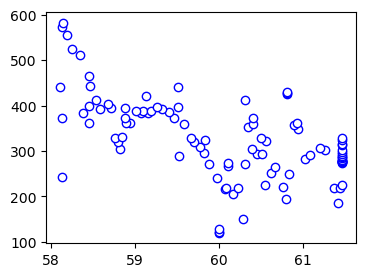

In [21]:
fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(combined_angara['lat_w'], combined_angara['co2_w'], c='white', ec='blue')

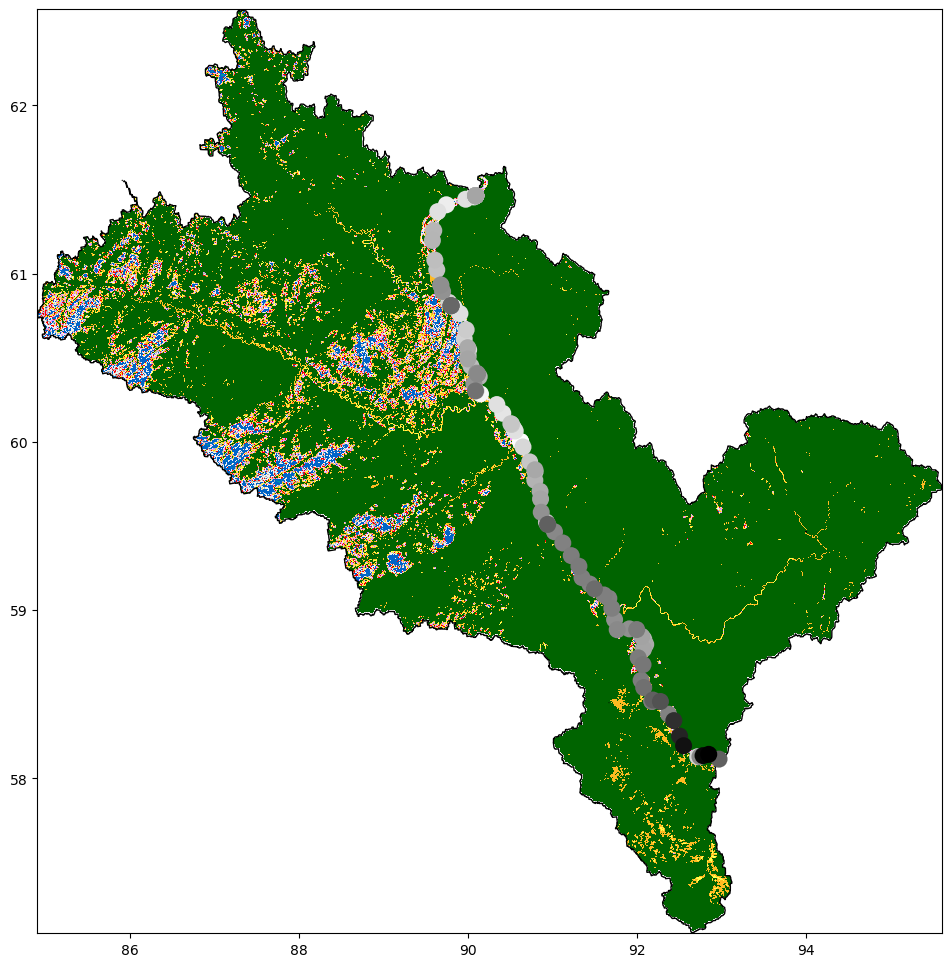

In [22]:
with rasterio.open(output_file) as src:
    data = src.read(1)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
# Plotting the GeoDataFrames as subplots
fig, ax = plt.subplots(figsize=(12, 12))

# Raster Data
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) 
# Vector Data
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1)

# Scatters
m1 = ax.scatter(combined_angara['lon_w'], combined_angara['lat_w'], 
                c=combined_angara['co2_w'], cmap='Greys',
                #vmin=angara_1a['co2_w'].quantile(0.05), 
                #vmax=angara_1a['co2_w'].quantile(0.95), 
                marker='o', s=150, linewidth=1, edgecolor='none', zorder=9) 


In [23]:
# Reka Bolshoy Pit is the tributary 

(59.0, 61.25)

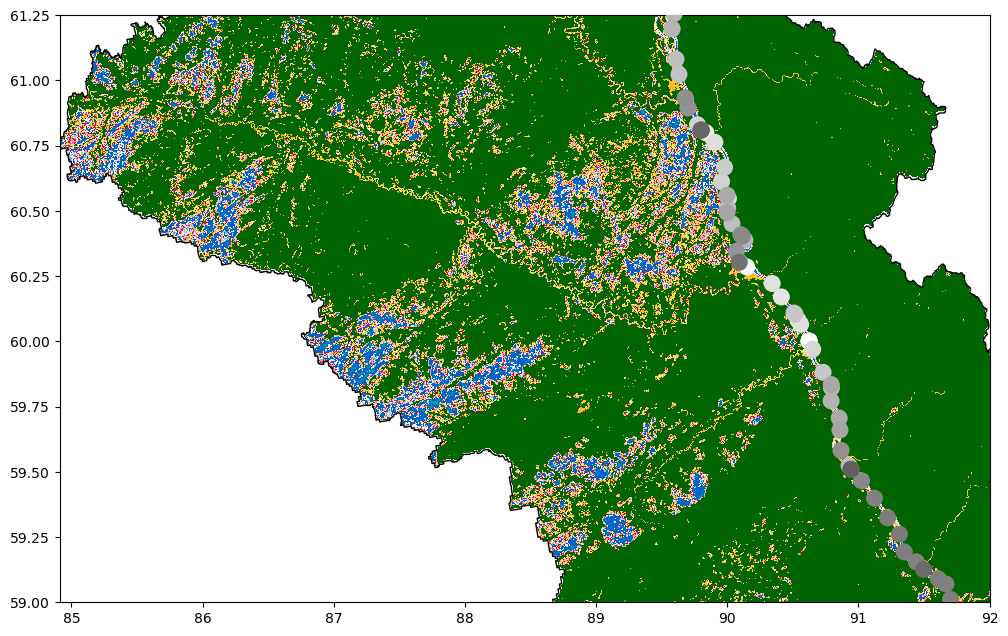

In [24]:
with rasterio.open(output_file) as src:
    data = src.read(1)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
# Plotting the GeoDataFrames as subplots
fig, ax = plt.subplots(figsize=(12, 12))

# Raster Data
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) 
# Vector Data
angara_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1)

# Scatters
m1 = ax.scatter(combined_angara['lon_w'], combined_angara['lat_w'], 
                c=combined_angara['co2_w'], cmap='Greys',
                #vmin=angara_1a['co2_w'].quantile(0.05), 
                #vmax=angara_1a['co2_w'].quantile(0.95), 
                marker='o', s=150, linewidth=1, edgecolor='none', zorder=9) 

xminac, yminac, xmaxac, ymaxac = angara_confluence.total_bounds

ax.set_xlim(xminac, 92)
ax.set_ylim(59, 61.25)